In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
import datetime
import category_encoders as ce
import pandas as pd

from ddop.newsvendor import RandomForestWeightedNewsvendor
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [3]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

In [4]:
df = pd.read_csv(path_ds/'dataforprediction_V2.csv')
df = df[df.artNr.isin([101,109,110])]
fils = [19,24,27,33,34]
df = df[df.FilNr.isin(fils)]

cat_var = ['dayofWeek', 'month', 'State']
num_var = ['RSK', 'TMK', 'TXK', 'TNK']
bin_var = ['currentWeek_Keine Anzeige',
           'currentWeek_3+1Aktion', 'currentWeek_2+1Aktion', 
           'currentWeek_info', 'lastWeek_Keine Anzeige',
           'lastWeek_3+1Aktion', 'lastWeek_2+1Aktion', 'lastWeek_info', 'schoolholidays', 'isHolyday', 'isHolydayNext2Days']
df = df.drop(columns = df.columns.difference(cat_var+bin_var+num_var+['daySalesUnit', 'shortDate', 'artNr', 'FilNr']))

df[bin_var] = df[bin_var].astype('int')

df.rename(columns={'shortDate': 'DEMAND_DATE'}, inplace=True)
df['DEMAND_DATE'] = pd.to_datetime(df['DEMAND_DATE'])

df.set_index('DEMAND_DATE', inplace = True)
df['DEMAND_DATE'] = df.index
df['DEMAND_DATE'] = (df['DEMAND_DATE'] - datetime.datetime(1970,1,1)).astype('timedelta64[D]').values

selected_columns = df.columns.difference(['daySalesUnit']).tolist() + ['daySalesUnit']
df_raw = df[selected_columns].copy()

In [6]:
res = []
#for method in ['saa', 'timeseries', 'one-hot encoding', 'target encoding', 'week_of_month_one-hot', 'week_of_month_target']:
for method in ['saa', 'timeseries', 'one-hot encoding', 'target encoding']:
    for fil in fils:
        for target in [101,109,110]:

            if method == 'timeseries':
                df = df_raw.loc[(df_raw.artNr==target) & (df_raw.FilNr == fil),['DEMAND_DATE', 'daySalesUnit']]

            else:
                df = df_raw[(df_raw.artNr==target) & (df_raw.FilNr == fil)].copy()
                df = df.drop(columns = ['DEMAND_DATE', 'artNr'])

            # make train/val/test
            train_x_df, train_y_df = df.loc[df.index<pd.to_datetime('2018-04-30'), df.columns.difference(['daySalesUnit'])], df.loc[df.index<pd.to_datetime('2018-04-30'), 'daySalesUnit']
            test_x_df, test_y_df = df.loc[~(df.index<pd.to_datetime('2018-04-30')), df.columns.difference(['daySalesUnit'])], df.loc[~(df.index<pd.to_datetime('2018-04-30')), 'daySalesUnit']

            train_y = train_y_df.values
            test_y = test_y_df.values

            # target encoding
            if method == 'target encoding':
                for cat in cat_var:
                    encoder = ce.TargetEncoder()
                    train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)
                    test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))

            elif method == 'one-hot encoding':
                for cat in cat_var:
                    encoder = ce.OneHotEncoder()
                    train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)], axis=1).drop(columns = cat)
                    test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)

            if method != 'saa':
                scaler = MinMaxScaler()
                scaler.fit(train_x_df)

                train_x = scaler.transform(train_x_df)
                test_x = scaler.transform(test_x_df)

                # Kernel with parameters given in GPML book
                k1 = 1**2 * RBF(length_scale=0.261)  # long term smooth rising trend
                k2 = 2.4**2 * RBF(length_scale=90.0) \
                    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
                k3 = 0.66**2 \
                    * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
                k4 = 0.18**2 * RBF(length_scale=0.134) \
                    + WhiteKernel(noise_level=1.09**2)  # noise terms

                if method == 'timeseries':
                    kernel_gpml = k1 + k2 + k3 + k4

                else:
                    kernel_gpml = k1 + k4

                gp = GaussianProcessRegressor(kernel=kernel_gpml, normalize_y=True)#, alpha=1)
                gp.fit(train_x, train_y)

                print("\nLearned kernel: %s" % gp.kernel_)
                print("Log-marginal-likelihood: %.3f"
                      % gp.log_marginal_likelihood(gp.kernel_.theta))

                nv_means, y_std = gp.predict(test_x,  return_std=True)
                nv_sigma = y_std

            for c in range(5,100, 5):
                cu = c/100
                co = 1-cu

                if method == 'saa':
                    nv_quantile = np.quantile(train_y, q=cu/(cu+co))
                    cost= np.mean([nv_cost(nv_quantile, y, cu, co) for y in test_y])
                else:
                    nv_solution = nv_means+norm.ppf(cu/(cu+co))*nv_sigma
                    cost =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, test_y)])

                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "Filiale": fil})
                res.append(ser_tmp)
        df_res = pd.DataFrame(res)


Learned kernel: 0.00316**2 * RBF(length_scale=389) + 0.00316**2 * RBF(length_scale=90.2) * ExpSineSquared(length_scale=0.0914, periodicity=1.67) + 0.0338**2 * RationalQuadratic(alpha=2.55, length_scale=0.188) + 0.345**2 * RBF(length_scale=0.147) + WhiteKernel(noise_level=0.883)
Log-marginal-likelihood: -1160.482

Learned kernel: 0.00319**2 * RBF(length_scale=0.782) + 0.295**2 * RBF(length_scale=89.9) * ExpSineSquared(length_scale=0.0572, periodicity=0.69) + 0.00316**2 * RationalQuadratic(alpha=0.819, length_scale=5.33) + 0.195**2 * RBF(length_scale=0.0313) + WhiteKernel(noise_level=0.878)
Log-marginal-likelihood: -1183.047

Learned kernel: 0.343**2 * RBF(length_scale=0.24) + 0.00316**2 * RBF(length_scale=92) * ExpSineSquared(length_scale=9.98e+04, periodicity=36.4) + 0.00316**2 * RationalQuadratic(alpha=0.223, length_scale=282) + 0.00316**2 * RBF(length_scale=9.62e+04) + WhiteKernel(noise_level=0.875)
Log-marginal-likelihood: -1154.592

Learned kernel: 0.00316**2 * RBF(length_scale=28

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.74**2 * RBF(length_scale=2.26) + 0.0359**2 * RBF(length_scale=0.0128) + WhiteKernel(noise_level=0.366)
Log-marginal-likelihood: -922.307


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.4**2 * RBF(length_scale=2.01) + 0.0215**2 * RBF(length_scale=0.0038) + WhiteKernel(noise_level=0.411)
Log-marginal-likelihood: -964.814


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.03**2 * RBF(length_scale=2.64) + 0.0068**2 * RBF(length_scale=0.00487) + WhiteKernel(noise_level=0.481)
Log-marginal-likelihood: -1017.711


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.38**2 * RBF(length_scale=1.66) + 0.114**2 * RBF(length_scale=0.0705) + WhiteKernel(noise_level=0.163)
Log-marginal-likelihood: -707.762


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.24**2 * RBF(length_scale=1.67) + 0.00316**2 * RBF(length_scale=0.00578) + WhiteKernel(noise_level=0.147)
Log-marginal-likelihood: -644.527


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.3**2 * RBF(length_scale=1.6) + 0.298**2 * RBF(length_scale=0.0938) + WhiteKernel(noise_level=0.354)
Log-marginal-likelihood: -1020.286


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.27**2 * RBF(length_scale=1.72) + 0.149**2 * RBF(length_scale=0.0995) + WhiteKernel(noise_level=0.12)
Log-marginal-likelihood: -602.652


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.18**2 * RBF(length_scale=1.76) + 0.372**2 * RBF(length_scale=0.0294) + WhiteKernel(noise_level=0.0347)
Log-marginal-likelihood: -665.601


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.24**2 * RBF(length_scale=1.86) + 0.136**2 * RBF(length_scale=0.133) + WhiteKernel(noise_level=0.324)
Log-marginal-likelihood: -897.922


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.32**2 * RBF(length_scale=1.91) + 0.188**2 * RBF(length_scale=0.152) + WhiteKernel(noise_level=0.145)
Log-marginal-likelihood: -649.700


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.36**2 * RBF(length_scale=2.44) + 0.0468**2 * RBF(length_scale=0.335) + WhiteKernel(noise_level=0.11)
Log-marginal-likelihood: -456.423


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.64**2 * RBF(length_scale=2.99) + 0.00316**2 * RBF(length_scale=0.00805) + WhiteKernel(noise_level=0.279)
Log-marginal-likelihood: -771.858


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.43**2 * RBF(length_scale=2.07) + 0.00737**2 * RBF(length_scale=0.0103) + WhiteKernel(noise_level=0.213)
Log-marginal-likelihood: -720.172


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.27**2 * RBF(length_scale=1.73) + 0.00316**2 * RBF(length_scale=0.0422) + WhiteKernel(noise_level=0.154)
Log-marginal-likelihood: -651.199


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.4**2 * RBF(length_scale=2.11) + 0.218**2 * RBF(length_scale=0.11) + WhiteKernel(noise_level=0.374)
Log-marginal-likelihood: -960.309


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.65**2 * RBF(length_scale=1.31) + 0.255**2 * RBF(length_scale=0.222) + WhiteKernel(noise_level=0.371)
Log-marginal-likelihood: -884.138


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.45**2 * RBF(length_scale=1.31) + 0.0633**2 * RBF(length_scale=0.216) + WhiteKernel(noise_level=0.436)
Log-marginal-likelihood: -918.714


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.5**2 * RBF(length_scale=2.15) + 0.389**2 * RBF(length_scale=0.325) + WhiteKernel(noise_level=0.455)
Log-marginal-likelihood: -973.795


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.96**2 * RBF(length_scale=1.28) + 0.319**2 * RBF(length_scale=0.108) + WhiteKernel(noise_level=0.136)
Log-marginal-likelihood: -623.722


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.26) + 0.437**2 * RBF(length_scale=0.543) + WhiteKernel(noise_level=0.161)
Log-marginal-likelihood: -573.605


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 2.03**2 * RBF(length_scale=1.25) + 0.366**2 * RBF(length_scale=0.253) + WhiteKernel(noise_level=0.396)
Log-marginal-likelihood: -952.145


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.67**2 * RBF(length_scale=1.41) + 0.342**2 * RBF(length_scale=0.495) + WhiteKernel(noise_level=0.173)
Log-marginal-likelihood: -569.796


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.14) + 0.44**2 * RBF(length_scale=0.332) + WhiteKernel(noise_level=0.155)
Log-marginal-likelihood: -603.454


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.77**2 * RBF(length_scale=1.68) + 0.646**2 * RBF(length_scale=0.294) + WhiteKernel(noise_level=0.279)
Log-marginal-likelihood: -835.892


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.54**2 * RBF(length_scale=1.24) + 0.314**2 * RBF(length_scale=0.179) + WhiteKernel(noise_level=0.146)
Log-marginal-likelihood: -578.395


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.43**2 * RBF(length_scale=1.43) + 0.315**2 * RBF(length_scale=0.444) + WhiteKernel(noise_level=0.102)
Log-marginal-likelihood: -382.676


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.69**2 * RBF(length_scale=1.73) + 0.176**2 * RBF(length_scale=0.212) + WhiteKernel(noise_level=0.267)
Log-marginal-likelihood: -731.721


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.61**2 * RBF(length_scale=1.36) + 0.131**2 * RBF(length_scale=0.14) + WhiteKernel(noise_level=0.217)
Log-marginal-likelihood: -662.409


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.55**2 * RBF(length_scale=1.25) + 0.159**2 * RBF(length_scale=0.237) + WhiteKernel(noise_level=0.171)
Log-marginal-likelihood: -582.397


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.86**2 * RBF(length_scale=1.66) + 0.29**2 * RBF(length_scale=0.272) + WhiteKernel(noise_level=0.409)
Log-marginal-likelihood: -922.061


nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

In [7]:
df = pd.read_csv(path_ds/'dataforprediction_V2.csv')
df = df[df.artNr.isin([101,109,110])]
fils = [19,24,27,33,34]
df = df[df.FilNr.isin(fils)]

cat_var = ['dayofWeek', 'month', 'State', 'artNr', 'FilNr']
num_var = ['RSK', 'TMK', 'TXK', 'TNK']
bin_var = ['currentWeek_Keine Anzeige',
           'currentWeek_3+1Aktion', 'currentWeek_2+1Aktion', 
           'currentWeek_info', 'lastWeek_Keine Anzeige',
           'lastWeek_3+1Aktion', 'lastWeek_2+1Aktion', 'lastWeek_info', 'schoolholidays', 'isHolyday', 'isHolydayNext2Days']
df = df.drop(columns = df.columns.difference(cat_var+bin_var+num_var+['daySalesUnit', 'shortDate']))

df[bin_var] = df[bin_var].astype('int')

df.rename(columns={'shortDate': 'DEMAND_DATE'}, inplace=True)
df['DEMAND_DATE'] = pd.to_datetime(df['DEMAND_DATE'])

df.set_index('DEMAND_DATE', inplace = True)
df['DEMAND_DATE'] = df.index
df['DEMAND_DATE'] = (df['DEMAND_DATE'] - datetime.datetime(1970,1,1)).astype('timedelta64[D]').values

selected_columns = df.columns.difference(['daySalesUnit']).tolist() + ['daySalesUnit']
df_raw = df[selected_columns].copy()

In [ ]:
#res = []
for method in ['one-hot encoding', 'target encoding']:

    df = df_raw.copy()
    df = df.drop(columns = ['DEMAND_DATE'])

    # make train/val/test
    train_x_df, train_y_df = df.loc[df.index<pd.to_datetime('2018-04-30'), df.columns.difference(['daySalesUnit'])], df.loc[df.index<pd.to_datetime('2018-04-30'), ['artNr', 'FilNr', 'daySalesUnit']]
    test_x_df, test_y_df = df.loc[~(df.index<pd.to_datetime('2018-04-30')), df.columns.difference(['daySalesUnit'])], df.loc[~(df.index<pd.to_datetime('2018-04-30')), ['artNr', 'FilNr', 'daySalesUnit']]

    train_y = train_y_df.iloc[:,-1].values

    # target encoding
    if method == 'target encoding':
        for cat in cat_var:
            encoder = ce.TargetEncoder()
            train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df.iloc[:,-1])
            test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))

    elif method == 'one-hot encoding':
        for cat in cat_var:
            encoder = ce.OneHotEncoder()
            train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df.iloc[:,-1])], axis=1).drop(columns = cat)
            test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)
            
    scaler = MinMaxScaler()
    scaler.fit(train_x_df)
    train_x = scaler.transform(train_x_df)
    
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        
        mdl_rf = RandomForestWeightedNewsvendor(cu=cu, co=co, verbose=1)
        mdl_rf.fit(train_x, train_y)
        
        for i, fil in enumerate(fils, 1):
            for k, target in enumerate([101,109,110], 1):

                test_x = scaler.transform(test_x_df[(test_x_df["artNr_"+str(k)]==1) & (test_x_df["FilNr_"+str(i)]==1)])
                test_y = test_y_df.loc[(test_y_df.artNr==target) & (test_y_df.FilNr==fil),'daySalesUnit'].values

                cost =  np.abs(mdl_rf.score(test_x, test_y))

                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":'wsaa'+method, "target": target, "Filiale": fil})
                res.append(ser_tmp)

df_res = pd.DataFrame(res)

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom

In [ ]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
#df_plot = df_plot[~(df_plot.type.isin(["timeseries", "one-hot encoding", "week_of_month_target", "week_of_month_one-hot"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",facet_kws={'sharey':False}, row='Filiale',
    col="target", hue="type",kind="line", aspect=1, height=4); 

In [ ]:
df_res.to_csv('res_data/baeckerei.csv')

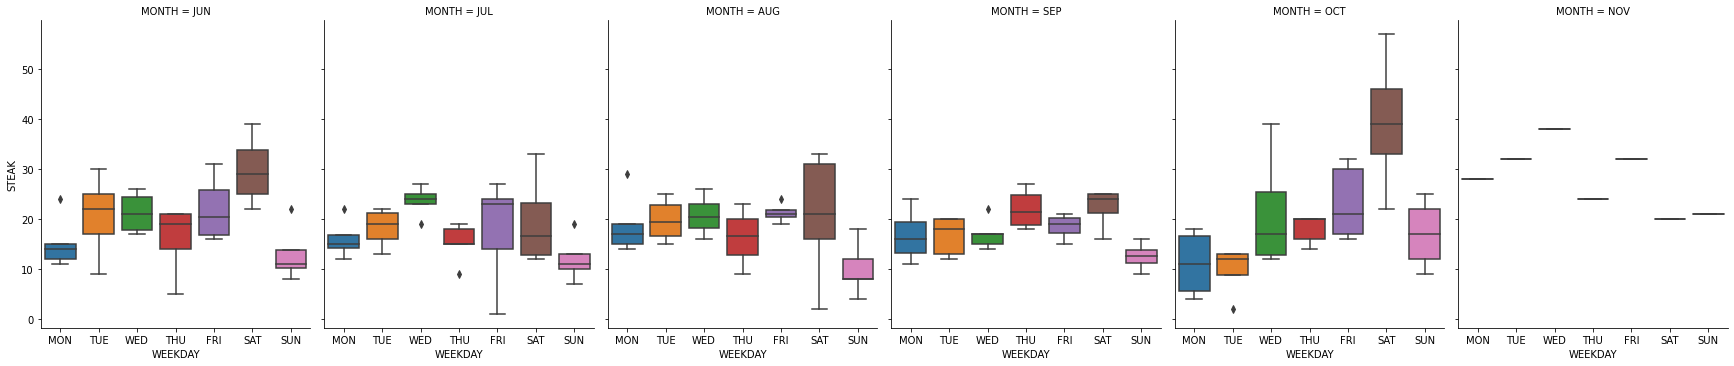

In [8]:
test_df = load_yaz(encode_date_features=False, include_prod=[target]).frame.iloc[n_train:,:].copy()
test_df['mean_pred'] =nv_means
test_df['std'] = nv_sigma


g = sns.catplot(x="WEEKDAY", y="STEAK",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

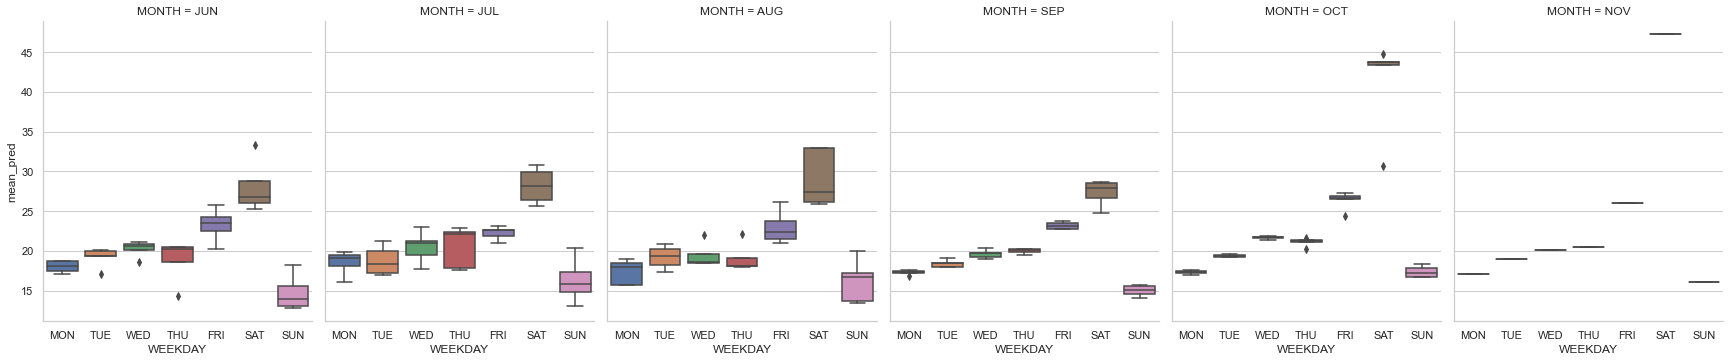

In [87]:
g = sns.catplot(x="WEEKDAY", y="mean_pred",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

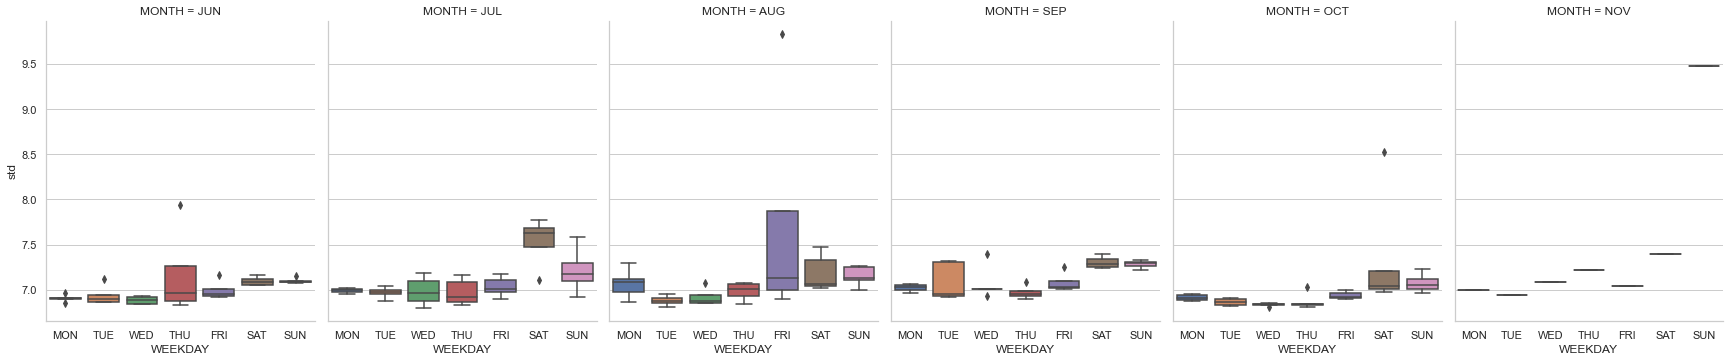

In [88]:
g = sns.catplot(x="WEEKDAY", y="std",
                col="MONTH",# hue="MONTH",
                aspect=.8,
                data=test_df, kind="box");

## Plot Space

In [46]:
f0 = [torch.linspace(0, 1, 200) for i in range(1)]
fx = torch.linspace(1,1, 200) #temp
fn = [torch.linspace(0, 1, 200) for i in range(5)]#[torch.linspace(0.5, 0.5, 200) for i in range(2)]


In [47]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    sample_x = torch.stack([*f0,fx,*fn] , axis=-1).cuda()
    observed_pred = likelihood(model(sample_x))

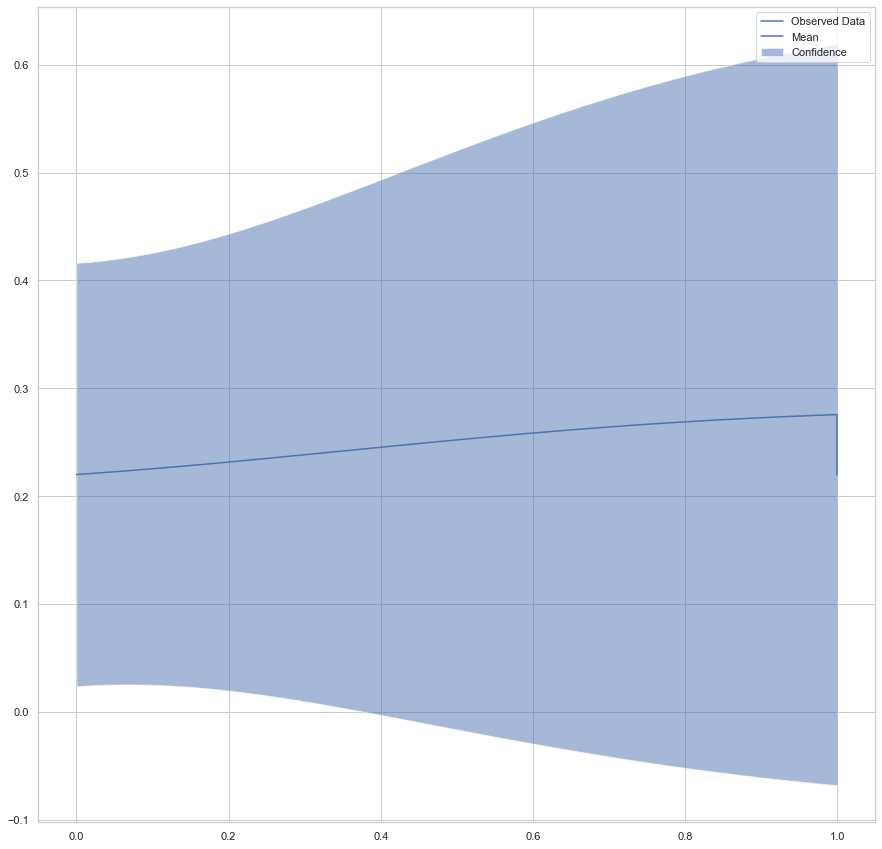

In [48]:
feature_idx=2
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(train_x[:,feature_idx].cpu().numpy(), train_y.cpu().numpy(), 'k*')
    #ax.plot(sample_x[:,feature_idx].cpu().numpy(), y_samples.cpu().numpy(), lw=1)
    # Plot predictive means as blue line
    ax.plot(fx.numpy(), observed_pred.mean.cpu().numpy(), 'b')
    ax.plot(sample_x[:,feature_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.fill_between(sample_x[:,feature_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])